# Redspots Environment

## Environment Description

A simple gridworld with white (safe) spots, green (rewarding) spots, and red (undesirable/dangerous) spots.

## Goal

Have an agent map the environment and infer the best way to avoid red spots and get to the green spot.

# Setup

## Imports

In [102]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm

import seaborn as sns

import pymdp
from pymdp import utils

## Auxilary Functions

In [103]:
from auxilaryfunctions import plot_grid, add_noise, plot_likelihood, plot_beliefs

## Parameters

### Grid

In [104]:
# grid_dimensions
grid_dims = [8,5]

# list of grid positiions
grid_locations = []
for i in range(grid_dims[0]):
    for j in range(grid_dims[1]):
        grid_locations.append((i,j))

In [105]:
redspots = [(1,2), (3,2), (4,4), (6,1)]

In [106]:
# start point
agent_pos = (0,0)

# end goal
goal_location = (6,4)

## Generative Model

### States & Observations

s1 = current location \
s2 = attribute of current location

o1 = observed current location \
o2 = color of current location

In [107]:
# s1 is already defined = grid_locations

# s2
current_attribute = ['SAFE', 'DANGER', 'REWARDING']

# list of # of possibillities for states
num_states = [len(grid_locations), len(current_attribute)] # location

In [108]:
# o1 is already defined = grid_locatioons

# o2
current_color = ['WHITE', 'RED', 'GREEN']

# list of # of possibilities for observations
num_obs = [len(grid_locations), len(current_color)]

# Generative Model

## Rule-based Matrix

In [109]:
rule_matrix = np.zeros((num_states[0], num_states[1]))

# Rule-based assignment
for loc in range(num_states[0]):
    # Example: Assume all locations have [SAFE: 0.7, DANGER: 0.2, REWARDING: 0.1]
    rule_matrix[loc] = np.array([0.33, 0.33, 0.33])
    rule_matrix[loc] /= rule_matrix[loc].sum()

    # Normalize each location's attribute distribution (ensure sum = 1)

rule_matrix

array([[0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.

In [110]:
# red, green, white, one-hot encoded
# rule_matrix -> white, red, green -> safe, dangerous, rewarding

def update_rule_matrix(rule_matrix, beliefs):

    # Take current location
    s1 = np.argmax(beliefs[0])

    # Take safety belief
    s2 = np.argmax(beliefs[1])

    # one hot encoding
    if s2 == 0: rule_matrix[s1] = [1, 0, 0]
    elif s2 == 1: rule_matrix[s1] = [0, 1, 0]
    else: rule_matrix[s1] = [0, 0, 1]

    return rule_matrix

## A Matrix

In [111]:
# Define A Matrix
A_shapes = []
for i in num_obs:
    A_shapes.append([i] + num_states)

A = utils.obj_array_zeros(A_shapes)
A.shape, A_shapes

((2,), [[40, 40, 3], [3, 40, 3]])

### Location Observation Modality A[0]

In [112]:
A[0] = np.zeros(A_shapes[0])  # Initialize with zeros

# Fill in the observation mapping for each safety level
for safety_level in range(num_states[1]):
    A[0][:,:,safety_level] = np.eye(num_states[0])  # Copy the identity matrix for each safety level

# Verify the shape and normalization
print("New A[0] shape:", A[0].shape)
print("Column sums:", A[0].sum(axis=0).sum(axis=1))  # Should be all 1's

New A[0] shape: (40, 40, 3)
Column sums: [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]


In [113]:
# Extract a 2D slice by fixing all other dimensions to 0
import numpy as np
plot_likelihood(A[0][:, :, :], "Location observation likelihood matrix")

NameError: name 'np' is not defined

### Color observation modality: A[1]

In [114]:
# Map safety levels to indices
safety_level_to_index = {state: i for i, state in enumerate(current_attribute)}  # {'SAFE': 0, 'DANGER': 1, 'REWARDING': 2}

# Probabilities for each color given the safety level (in correct heatmap order: RED, GREEN, WHITE)
probabilities = {
    "SAFE": [1, 0, 0],        # ['WHITE', 'RED', 'GREEN']
    "DANGER": [0, 1, 0.],      # ['WHITE', 'RED', 'GREEN']
    "REWARDING": [0, 0, 1]    # ['WHITE', 'RED', 'GREEN']
}

In [115]:
# Populate A[1]
for safety_level, probs in probabilities.items():
    safety_idx = safety_level_to_index[safety_level]
    for loc in range(len(grid_locations)):  # Iterate over grid locations
        for color_idx, prob in enumerate(probs):  # Iterate over colors (RED, GREEN, WHITE)
            A[1][color_idx, loc, safety_idx] = prob  # Assign probabilities

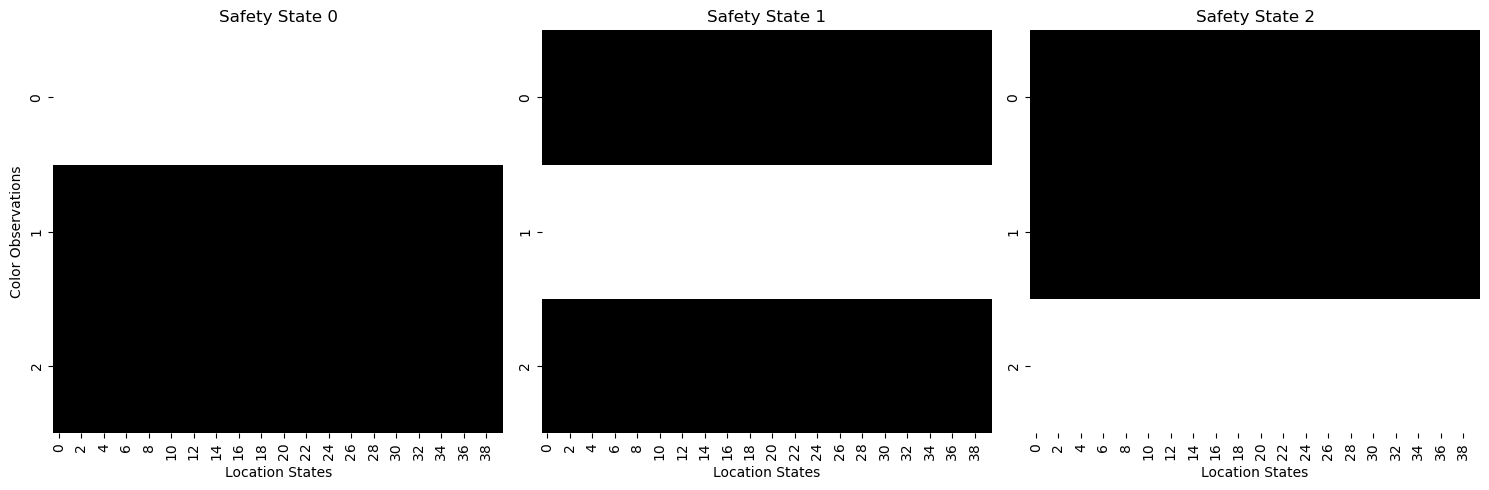

In [116]:
# Create a figure with 3 subplots (one for each safety state)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Extract and plot each safety state slice
for safety_idx in range(3):
    # Get a slice for the current safety state (fixing all other dimensions to 0)
    slice_matrix = A[1][:, :, safety_idx]
    
    # Plot the slice
    sns.heatmap(slice_matrix, ax=axes[safety_idx], cmap='gray', cbar=False, vmin=0.0, vmax=1.0)
    axes[safety_idx].set_title(f'Safety State {safety_idx}')
    axes[safety_idx].set_xlabel('Location States')
    if safety_idx == 0:
        axes[safety_idx].set_ylabel('Color Observations')

plt.tight_layout()
plt.show()

### Add Noise

In [117]:
# Add noise to each modality separately
for modality in range(len(A)):
    A[modality] = add_noise(A[modality], noise_level=0)

NameError: name 'np' is not defined

### Plot Each Matrix

## B Matrix

### Define Shape

In [125]:
num_controls = [5, 1]
B_f_shapes = [ [ns, ns, num_controls[f]] for f, ns in enumerate(num_states)]
B = utils.obj_array_zeros(B_f_shapes)
B_f_shapes

[[40, 40, 5], [3, 3, 1]]

### B[0] - Control Factor - Location Transitions

In [126]:
grid_dims

[8, 5]

In [127]:
actions = ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]

In [128]:
for action_id, action_label in enumerate(actions):
  
    for curr_state, (x, y) in enumerate(grid_locations):
        
        # Calculate next position based on action
        if action_label == "UP":
            next_y = max(0, y - 1)        # Move up (decrease y)
            next_x = x
        elif action_label == "DOWN":
            next_y = min(grid_dims[1]-1, y + 1)  # Move down (increase y)
            next_x = x
        elif action_label == "LEFT":
            next_x = max(0, x - 1)        # Move left (decrease x)
            next_y = y
        elif action_label == "RIGHT":
            next_x = min(grid_dims[0]-1, x + 1)  # Move right (increase x)
            next_y = y
        else:  # STAY
            next_x = x
            next_y = y
        
        # Get the state index for the next position
        next_state = grid_locations.index((next_x, next_y))
        
        # Set transition probability to 1.0
        B[0][next_state, curr_state, action_id] = 1.0

### B[1] - Non-Control Factor - Identity Matrix

In [129]:
# Initialize safety level transition matrix (no changes for safety levels)
B[1][:,:,0] = np.eye(3)  # Identity matrix for safety level transitions

### Normalization

In [131]:
# Normalize B matrix columns for each action
for action_id in range(len(actions)):
    # Get slice for current action
    B_action = B[0][..., action_id]
    
    # Replace zero columns with ones in appropriate positions
    zero_cols = (B_action.sum(axis=0) == 0)
    for col in range(B_action.shape[1]):
        if zero_cols[col]:
            # Stay in the same state if no transition is defined
            B_action[col, col] = 1.0
    
    # Normalize columns
    column_sums = B_action.sum(axis=0)
    B[0][..., action_id] = B_action / column_sums[None, :]

# Verify normalization
for action_id in range(len(actions)):
    assert np.allclose(B[0][..., action_id].sum(axis=0), 1.0), f"Action {actions[action_id]} not normalized"

In [132]:
print(B[1])

[[[1.]
  [0.]
  [0.]]

 [[0.]
  [1.]
  [0.]]

 [[0.]
  [0.]
  [1.]]]


## C Vectors (prior preferences)

### Initialize

In [133]:
C = utils.obj_array_zeros(num_obs)  # Initialize C array with shape matching num_obs
print(C.shape)

(2,)


### C[0] - Preference for location observations

In [134]:
goal_location

(6, 4)

In [135]:
# Set preferences for state observations (location)
C[0] = np.ones(len(grid_locations))
C[0][grid_locations.index(goal_location)] += 1

print(C[0])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1.]


In [136]:
for i, loc in enumerate(grid_locations):
    x = ((goal_location[0] - loc[0])**2 + (goal_location[1] - loc[1])**2) ** 0.5
    print(loc, i, x)
    C[0][i] -= x * 0.1

(0, 0) 0 7.211102550927978
(0, 1) 1 6.708203932499369
(0, 2) 2 6.324555320336759
(0, 3) 3 6.082762530298219
(0, 4) 4 6.0
(1, 0) 5 6.4031242374328485
(1, 1) 6 5.830951894845301
(1, 2) 7 5.385164807134504
(1, 3) 8 5.0990195135927845
(1, 4) 9 5.0
(2, 0) 10 5.656854249492381
(2, 1) 11 5.0
(2, 2) 12 4.47213595499958
(2, 3) 13 4.123105625617661
(2, 4) 14 4.0
(3, 0) 15 5.0
(3, 1) 16 4.242640687119285
(3, 2) 17 3.605551275463989
(3, 3) 18 3.1622776601683795
(3, 4) 19 3.0
(4, 0) 20 4.47213595499958
(4, 1) 21 3.605551275463989
(4, 2) 22 2.8284271247461903
(4, 3) 23 2.23606797749979
(4, 4) 24 2.0
(5, 0) 25 4.123105625617661
(5, 1) 26 3.1622776601683795
(5, 2) 27 2.23606797749979
(5, 3) 28 1.4142135623730951
(5, 4) 29 1.0
(6, 0) 30 4.0
(6, 1) 31 3.0
(6, 2) 32 2.0
(6, 3) 33 1.0
(6, 4) 34 0.0
(7, 0) 35 4.123105625617661
(7, 1) 36 3.1622776601683795
(7, 2) 37 2.23606797749979
(7, 3) 38 1.4142135623730951
(7, 4) 39 1.0


In [137]:
print(C[0])

[0.27888974 0.32917961 0.36754447 0.39172375 0.4        0.35968758
 0.41690481 0.46148352 0.49009805 0.5        0.43431458 0.5
 0.5527864  0.58768944 0.6        0.5        0.57573593 0.63944487
 0.68377223 0.7        0.5527864  0.63944487 0.71715729 0.7763932
 0.8        0.58768944 0.68377223 0.7763932  0.85857864 0.9
 0.6        0.7        0.8        0.9        2.         0.58768944
 0.68377223 0.7763932  0.85857864 0.9       ]


In [138]:
from pymdp.maths import softmax

In [139]:
C[0] = softmax(C[0])

In [140]:
plot_beliefs(C[0])

NameError: name 'np' is not defined

### C[1] - Preference for color observations

In [141]:
# white, red, green <- order it's encoded in

In [142]:
# Set preferences for color observations
C[1] = np.zeros((num_obs[1],))
C[1][0] = -0.1
C[1][1] = -1
C[1][2] = 1.1

print(C[1])


[-0.1 -1.   1.1]


## D Vectors: Prior beliefs about hidden states

### Initialize

In [144]:
# Shape
num_states

[40, 3]

In [145]:
D = utils.obj_array_uniform(num_states)

### D[0] - Belief About Current Location

In [146]:
# Define prior belief about agent's location (same as before)
D[0] = np.zeros(num_states[0])  # Shape (35,)
D[0][grid_locations.index(agent_pos)] = 1.0  # One-hot encoding for location

print("D[0] shape (Location prior):", D[0].shape)  # (35,)
D[0]

D[0] shape (Location prior): (40,)


array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

In [147]:
# # Initialize uniform distribution over locations
# D[0] = np.ones(num_states[0]) / num_states[0]  # Create normalized uniform distribution over all locations

# D[0]

### D[1] - Belief About Attribute of Current Location

In [148]:
D[1] = np.ones(num_states[1]) / num_states[1]  # Create normalized uniform distribution over all locations
D[1].shape

(3,)

In [149]:
plot_beliefs(D[0])

NameError: name 'np' is not defined

In [150]:
plot_beliefs(D[1])

NameError: name 'np' is not defined

# Generative Process

In [152]:
def update_vision(current_location, grid_dims, distance):
    """
    Update the agent's field of vision based on the current location and distance
    Returns a list of all grid positions within the vision range
    
    Args:
        current_location (tuple): Current (x,y) position of the agent
        grid_dims (list): Dimensions of the grid [width, height]
        distance (int): Vision range/distance
        
    Returns:
        list: List of (x,y) tuples representing visible grid positions
    """
    x, y = current_location
    x_min = max(0, x - distance)
    x_max = min(grid_dims[0], x + distance + 1)
    y_min = max(0, y - distance)
    y_max = min(grid_dims[1], y + distance + 1)
    
    visible_locations = []
    for y_pos in range(y_min, y_max):
        for x_pos in range(x_min, x_max):
            visible_locations.append((x_pos, y_pos))
            
    return visible_locations

In [153]:
X, Y = 0, 0

In [154]:
class GridWorldEnv():
    def __init__(self, starting_loc=(0, 0), redspots=[(1, 2), (3, 2), (4, 4), (6, 1)], goal=(6,4)):
        # Initialize coordinates
        self.x, self.y = starting_loc
        self.init_loc = starting_loc
        self.current_location = (self.x, self.y)

        self.goal = goal

        self.redspots = redspots

        self.red_obs = ['Null']
        self.green_obs = 'Null'
        self.white_obs = ['Null']

        self.agent_reward = 0
        
        print(f"Starting location is {self.current_location} | Red spot locations are {self.redspots} | Goal is {self.goal}")
    
    def step(self, action_label):
        if action_label == "UP": 
            self.y = max(0, self.y - 1)  # Move up (decrease y)
            
        elif action_label == "DOWN": 
            self.y = min(grid_dims[1] - 1, self.y + 1)  # Move down (increase y)

        elif action_label == "LEFT": 
            self.x = max(0, self.x - 1)  # Move left (decrease x)

        elif action_label == "RIGHT": 
            self.x = min(grid_dims[0] - 1, self.x + 1)  # Move right (increase x)

        # Update current_location tuple after movement
        self.current_location = (self.x, self.y)
        print(f"self.current_location: {self.current_location}")
        
        # Update vision with current coordinates
        self.vision = update_vision(self.current_location, grid_dims, 6)

        self.loc_obs = self.current_location

        # Reset observations at each step
        self.red_obs = ['Null']
        self.white_obs = ['Null']
        self.green_obs = 'Null'

        # Update observations based on vision
        for spot in self.vision:
            if spot in self.redspots:
                if 'Null' in self.red_obs:
                    self.red_obs = [spot]
                else:
                    self.red_obs.append(spot)
            elif spot == self.goal:
                self.green_obs = spot
            else:
                if 'Null' in self.white_obs:
                    self.white_obs = [spot]
                else:
                    self.white_obs.append(spot)

        # Update rewards and observations based on current location
        if self.current_location in self.redspots:
            self.agent_reward -= 5
            if 'Null' in self.red_obs:
                self.red_obs = [self.current_location]
            else:
                self.red_obs.append(self.current_location)
        elif self.current_location == self.goal:
            self.agent_reward += 20
            self.green_obs = self.current_location
        else:
            if 'Null' in self.white_obs:
                self.white_obs = [self.current_location]
            else:
                self.white_obs.append(self.current_location)
        
        return self.loc_obs, self.green_obs, self.white_obs, self.red_obs, self.agent_reward
    
    def reset(self):
        self.x, self.y = self.init_loc
        self.current_location = (self.x, self.y)
        print(f'Re-initialized location to {self.current_location}')
        self.loc_obs = self.current_location
        self.green_obs, self.white_obs, self.red_obs, self.agent_reward = 'Null', ['Null'], ['Null'], 0

        return self.loc_obs, self.green_obs, self.white_obs, self.red_obs, self.agent_reward

# New Functions

In [168]:
import numpy as np
from pymdp import utils

class RuleMatrixAgent:
    def __init__(self, pymdp_agent, rule_matrix):
        self.agent = pymdp_agent
        self.rule_matrix = rule_matrix
        
    def infer_policies(self):
        """
        Policy inference using rule matrix to predict attributes of next locations
        """
        policies = self.agent.policies
        policy_values = np.zeros(len(policies))
        
        # Get current location from beliefs
        current_loc = np.argmax(self.agent.qs[0])
        
        for pol_idx, policy in enumerate(policies):
            # Get first action (you could extend this to consider full sequence)
            action = policy[0]
            
            # Use B[0] to predict next location
            next_loc_dist = self.agent.B[0][:, current_loc, action]
            next_loc = np.argmax(next_loc_dist)
            
            # Use rule matrix to predict attributes at next location
            predicted_attributes = self.rule_matrix[next_loc]
            
            # Calculate value components
            pragmatic_value = self._calculate_pragmatic_value(predicted_attributes)
            epistemic_value = self._calculate_epistemic_value(predicted_attributes)
            
            # Combine values (you can adjust these weights)
            policy_values[pol_idx] = pragmatic_value + 0.5 * epistemic_value
        
        # Convert to probabilities
        policy_probs = utils.softmax(-policy_values)  # Negative because we minimize free energy
        self.agent.q_pi = policy_probs
        
        return policy_probs
    
    def _calculate_pragmatic_value(self, predicted_attributes):
        """
        Calculate pragmatic value by comparing predicted attributes with preferences
        """
        # Get preferences from C matrix
        preferences = self.agent.C[1]  # Your preferences over attributes
        
        # Calculate how well predicted attributes match preferences
        # Using negative KL divergence as measure of alignment
        pragmatic_value = -np.sum(predicted_attributes * np.log(predicted_attributes / preferences + 1e-16))
        
        return pragmatic_value
    
    def _calculate_epistemic_value(self, predicted_attributes):
        """
        Calculate epistemic value (encourages exploration of uncertain locations)
        """
        # Calculate entropy of predictions (higher means more uncertain)
        entropy = -np.sum(predicted_attributes * np.log(predicted_attributes + 1e-16))
        
        return entropy
    
    def sample_action(self):
        """Use original agent's action sampling"""
        return self.agent.sample_action()

# Helper function to create predicted observations
def get_predicted_obs(location_id, attribute_beliefs, A):
    """
    Generate predicted observations given location and attribute beliefs
    """
    # Location observation (from A[0])
    loc_obs = A[0][:, location_id, :]  # Shape: [num_loc_obs, num_attr]
    
    # Attribute observation (from A[1])
    attr_obs = np.zeros(A[1].shape[0])  # Shape: [num_attr_obs]
    for attr_idx in range(len(attribute_beliefs)):
        attr_obs += attribute_beliefs[attr_idx] * A[1][:, location_id, attr_idx]
    
    return [loc_obs, attr_obs]

# Active Inference

In [155]:
from pymdp.agent import Agent

In [156]:
agent_pos, redspots, goal_location

((0, 0), [(1, 2), (3, 2), (4, 4), (6, 1)], (6, 4))

In [157]:
my_agent = Agent(A=A, B=B, C=C, D=D, policy_len=6)

my_env = GridWorldEnv(starting_loc = agent_pos, redspots=redspots, goal = goal_location)

Starting location is (0, 0) | Red spot locations are [(1, 2), (3, 2), (4, 4), (6, 1)] | Goal is (6, 4)


In [158]:
loc_obs, green_obs, white_obs, red_obs, agent_reward = my_env.reset()
loc_obs, green_obs, white_obs, red_obs, agent_reward

Re-initialized location to (0, 0)


((0, 0), 'Null', ['Null'], ['Null'], 0)

In [159]:
loc_obs, green_obs, white_obs, red_obs, agent_reward = my_env.step('STAY')

self.current_location: (0, 0)


In [160]:
loc_obs, green_obs, white_obs, red_obs, agent_reward

((0, 0),
 (6, 4),
 [(0, 0),
  (1, 0),
  (2, 0),
  (3, 0),
  (4, 0),
  (5, 0),
  (6, 0),
  (0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (0, 2),
  (2, 2),
  (4, 2),
  (5, 2),
  (6, 2),
  (0, 3),
  (1, 3),
  (2, 3),
  (3, 3),
  (4, 3),
  (5, 3),
  (6, 3),
  (0, 4),
  (1, 4),
  (2, 4),
  (3, 4),
  (5, 4),
  (0, 0)],
 [(6, 1), (1, 2), (3, 2), (4, 4)],
 0)

## Create Observation

In [161]:
loc_obs

(0, 0)

In [162]:
grid_locations

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4),
 (5, 0),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 4),
 (6, 0),
 (6, 1),
 (6, 2),
 (6, 3),
 (6, 4),
 (7, 0),
 (7, 1),
 (7, 2),
 (7, 3),
 (7, 4)]

In [163]:
def create_color_observation(position, red_obs, green_obs, white_obs):

    if red_obs != ['Null']:
        if position in red_obs: return 1  # RED
    if green_obs == position: return 2 # GREEN
    elif white_obs != ['Null']:
        if position in white_obs: return 0 # WHITE
    return 3

In [164]:
def create_observation(position, red_obs, green_obs, white_obs):
    return [grid_locations.index(position), create_color_observation(position, red_obs, green_obs, white_obs), create_color_observation((position[0] + 1, position[1]), red_obs, green_obs, white_obs), create_color_observation((position[0] - 1, position[1]), red_obs, green_obs, white_obs), create_color_observation((position[0], position[1] - 1), red_obs, green_obs, white_obs), create_color_observation((position[0], position[1] + 1), red_obs, green_obs, white_obs)]

## Loop

In [165]:
my_agent.qs[0], my_agent.qs[1]

(array([0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
        0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
        0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
        0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
        0.025, 0.025, 0.025, 0.025]),
 array([0.33333333, 0.33333333, 0.33333333]))

In [166]:
obs = create_observation(loc_obs, red_obs, green_obs, white_obs)
obs

[0, 0, 0, 3, 3, 0]

In [167]:
history_of_locs = [loc_obs]

T = 15

for t in range(T):

    obs = create_observation(loc_obs, red_obs, green_obs, white_obs)

    # generate observations
    print(f"Observation: {obs}")

    # belief posterior
    qs = my_agent.infer_states(obs) #directly updates using bayesian inference 

    # plot belief posterior
    plot_beliefs(qs[0])
    plot_beliefs(qs[1])

    # use belief posterior to update rule matrix
    rule_matrix = update_rule_matrix(rule_matrix, qs)
    print(f"Rule Matrix at loc {loc_obs}: {rule_matrix[obs[0]]}")

    # ruled based update on A
    # A = rule_based_update_A(rule_matrix, A)

    # plot updated A
    # plot_A_1(A)


    # policy selection
    my_agent.infer_policies()
    
    chosen_action_id = my_agent.sample_action()

    movement_id = int(chosen_action_id[0])

    choice_action = actions[movement_id]

    print(f'Action at time {t}: {choice_action}')

    
    loc_obs, green_obs, white_obs, red_obs, agent_reward = my_env.step(choice_action)
    
    print(agent_reward, loc_obs, green_obs, white_obs, red_obs)


    history_of_locs.append(loc_obs)

    print(f'Grid location at time {t}: {loc_obs}')

    print(f'Reward at time {t}: {agent_reward}')

Observation: [0, 0, 0, 3, 3, 0]


NameError: name 'np' is not defined